Find Changepoints
==========

I want to see the effect of a station closing or opening on the other stations in the system, most likely those stations either linked to it on the same line or those that are physically closer to each other.

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc3 as pm

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

user = 'mikemoran'
database = 'stations'

In [2]:
engine = create_engine(f'postgres://{user}@localhost/{database}')
conn = psycopg2.connect(database=database, user=user)

In [3]:
tables = ['second72', 'second86', 'second96',
          'g68', 'g77', 'g86', 'g96',
          'g103', 'g110', 'g116', 'g125']
renames = ['s72', 's86', 's96',
           'g68', 'g77', 'g86', 'g96',
           'g103', 'g110', 'g116', 'g125']

select = '{}.d_entries {}_in, {}.d_exits {}_out'
joins = 'left join {} {} on l.date = {}.date'

select_parts = ['select l.date, l.d_entries l_in, l.d_exits l_out']
join_parts = ['from lexington l']
for old, new in zip(tables, renames):
    new_select = select.format(new, new, new, new)
    select_parts.append(new_select)
    new_join = joins.format(old, new, new)
    join_parts.append(new_join)
select_str = ',\n'.join(select_parts)
query = '\n'.join([select_str, *join_parts, ';'])
print(query)

select l.date, l.d_entries l_in, l.d_exits l_out,
s72.d_entries s72_in, s72.d_exits s72_out,
s86.d_entries s86_in, s86.d_exits s86_out,
s96.d_entries s96_in, s96.d_exits s96_out,
g68.d_entries g68_in, g68.d_exits g68_out,
g77.d_entries g77_in, g77.d_exits g77_out,
g86.d_entries g86_in, g86.d_exits g86_out,
g96.d_entries g96_in, g96.d_exits g96_out,
g103.d_entries g103_in, g103.d_exits g103_out,
g110.d_entries g110_in, g110.d_exits g110_out,
g116.d_entries g116_in, g116.d_exits g116_out,
g125.d_entries g125_in, g125.d_exits g125_out
from lexington l
left join second72 s72 on l.date = s72.date
left join second86 s86 on l.date = s86.date
left join second96 s96 on l.date = s96.date
left join g68 g68 on l.date = g68.date
left join g77 g77 on l.date = g77.date
left join g86 g86 on l.date = g86.date
left join g96 g96 on l.date = g96.date
left join g103 g103 on l.date = g103.date
left join g110 g110 on l.date = g110.date
left join g116 g116 on l.date = g116.date
left join g125 g125 on l.date =

In [4]:
user = 'mikemoran'
host = 'localhost'
dbname = 'stations'

engine = create_engine(f'postgres://{user}@{host}/{dbname}')
conn = None
conn = psycopg2.connect(database=dbname, user=user)

df = pd.read_sql(query, conn)
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df_modern = df[df.date >= pd.datetime(2016, 1, 1)]
df, df_modern = df_modern, df
df.set_index('date', drop=True, inplace=True)
df.sort_index(inplace=True)
df.head()

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g96_in,g96_out,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,3302.0,3146.0,NaN,NaN,NaN,NaN,NaN,NaN,9521.0,7198.0,...,10097.0,2628.0,7678.0,7633.0,5749.0,5347.0,9343.0,5262.0,9084.0,13426.0
2016-01-02,4254.0,3987.0,NaN,NaN,NaN,NaN,NaN,NaN,4706.0,5430.0,...,6141.0,2913.0,6481.0,6787.0,5359.0,4253.0,7507.0,2970.0,10346.0,17843.0
2016-01-03,4173.0,3275.0,NaN,NaN,NaN,NaN,NaN,NaN,3401.0,4513.0,...,3682.0,2294.0,5143.0,6098.0,4219.0,3907.0,6427.0,2747.0,9516.0,17188.0
2016-01-04,8824.0,7496.0,NaN,NaN,NaN,NaN,NaN,NaN,28379.0,19186.0,...,24008.0,4968.0,14419.0,13755.0,12151.0,9270.0,15698.0,8035.0,19381.0,23519.0
2016-01-05,9622.0,7700.0,NaN,NaN,NaN,NaN,NaN,NaN,31805.0,19920.0,...,25705.0,5205.0,15140.0,14409.0,12226.0,9137.0,15590.0,8412.0,19085.0,23511.0


Focus just on people getting onto the subway, daily.

In [6]:
ins = [c for c in df.columns if c.endswith('in')]
df_ins = df[ins]
df_ins.head()

,l_in,s72_in,s86_in,s96_in,g68_in,g77_in,g86_in,g96_in,g103_in,g110_in,g116_in,g125_in
date,,,,,,,,,,,,
2015-01-01,7398.0,NaN,NaN,NaN,NaN,15109.0,25404.0,10332.0,7831.0,5881.0,8977.0,9688.0
2015-01-02,13755.0,NaN,NaN,NaN,NaN,27183.0,55702.0,17519.0,12518.0,9714.0,12870.0,15926.0
2015-01-03,8138.0,NaN,NaN,NaN,NaN,19250.0,41031.0,11078.0,9013.0,7063.0,10039.0,11807.0
2015-01-04,5495.0,NaN,NaN,NaN,NaN,15060.0,29698.0,8787.0,6949.0,5705.0,8752.0,9418.0
2015-01-05,16799.0,NaN,NaN,NaN,NaN,34694.0,62678.0,25469.0,16839.0,12307.0,16164.0,20581.0


Now, try to automatically detect the changepoint (Jan 1 2017) within the data...

In [24]:
def plot_verify(trace, data):
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    tau_samples = trace['tau']
    
    N = tau_samples.shape[0]
    expected_per_day = np.zeros(data.shape[0])
    for day in range(0, data.shape[0]):
        ix = day < tau_samples
        expected_per_day[day] = (lambda_1_samples[ix].sum()
                                       + lambda_2_samples[~ix].sum()) / N
    plt.plot(range(data.shape[0]), expected_per_day, lw=4, color="#E24A33",
             label="expected number of passengers")
    plt.xlabel("Day")
    plt.ylabel("Expected passengers")
    plt.title("Expected number of passengers")
    plt.bar(np.arange(data.shape[0]), data.values, color="#348ABD", alpha=0.65,
            label="observed passengers per day")
    plt.legend(loc="upper left")
    plt.show()

In [9]:
df.index.get_loc('2017-01-01')
# window = slice('2016-10-01', '2017-03-31')

731

In [7]:
def get_model_results(data, sample=1000, tune=500):
    with pm.Model() as model:
        mu = data.mean()
        lambda_1 = pm.Poisson('lambda_1', mu)
        lambda_2 = pm.Poisson('lambda_2', mu)

        tau = pm.DiscreteUniform('tau', lower=0, upper=data.shape[0])
        idx = np.arange(data.shape[0])  # Index
        lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
        observation = pm.Poisson('obs', lambda_, observed=data.values)
        step = pm.Metropolis()
        trace = pm.sample(sample, tune=tune, step=step)
    return trace

In [13]:
expected_tau = df.index.get_loc('2017-01-01')
window = slice(expected_tau - 45, expected_tau + 25)

def prediction(window):
    saved_traces = []
    for station in ins:
        data = df[station].fillna(0)
        data = data.iloc[window]
        trace = get_model_results(data, sample=10000, tune=5000)
        saved_traces.append(trace)
    return saved_traces

results = prediction(window)

100%|██████████| 10000/10000 [00:03<00:00, 3305.95it/s]


In [14]:
# trace_df = (pd.DataFrame({'station':ins, 'l1':saved_l1, 'l2':saved_l2})
#             .set_index('station'))
# #             .transpose())
# trace_df['p_diff'] = trace_df.diff(axis=1)['l2']
# trace_df['elas'] = trace_df.p_diff / trace_df.l1
# trace_df

Elasticity
------------

After speaking with Jesse, I can find the joint elasticity between stations, or (in my case) the joint elasticity between the 456 stations and the new Q extension. Since those stations opened as a whole, I can't really separate out their effects from each other.

Elasticity is the change in quantity sold of an item for a given change in price of that item. In my case, the quantity sold is ridership (number of riders entering a given station), and the price of that item is a "human" price (weather, walking distance, preference, etc.) that I cannot define for everyone. The shock events of opening a station changes the supply of subway rides available, and the new station has a cost associated with it for each person. For those people where the cost of the new station(s) is less than the other stations, they will switch stations, and the riders serviced by each will respond based on the elasticity for those stations when looked at on the whole.

Our model is still the `pymc3` one, where the hyperparameter we're tuning is the window around the shock event to use.

l_in


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


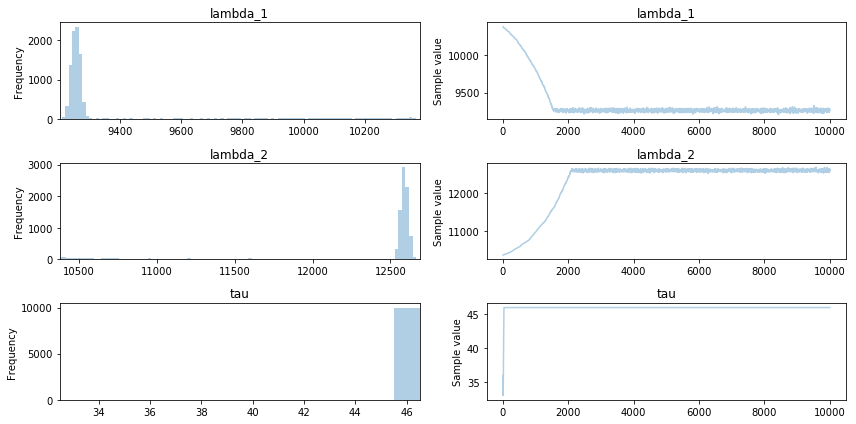

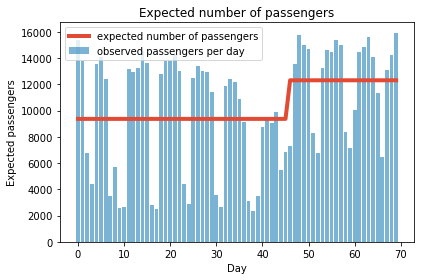

s72_in


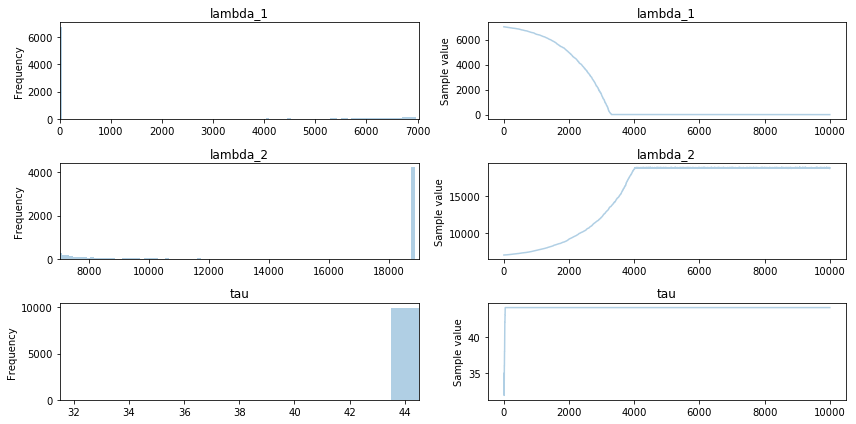

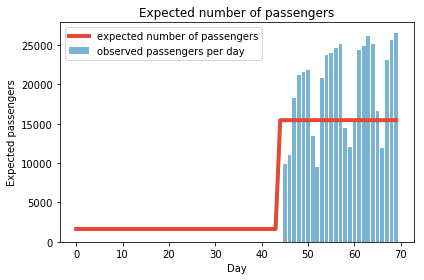

s86_in


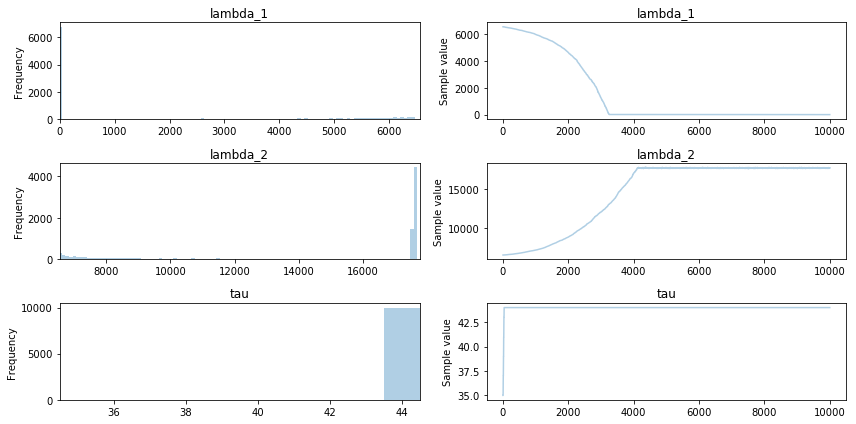

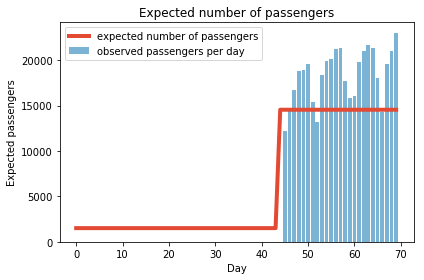

s96_in


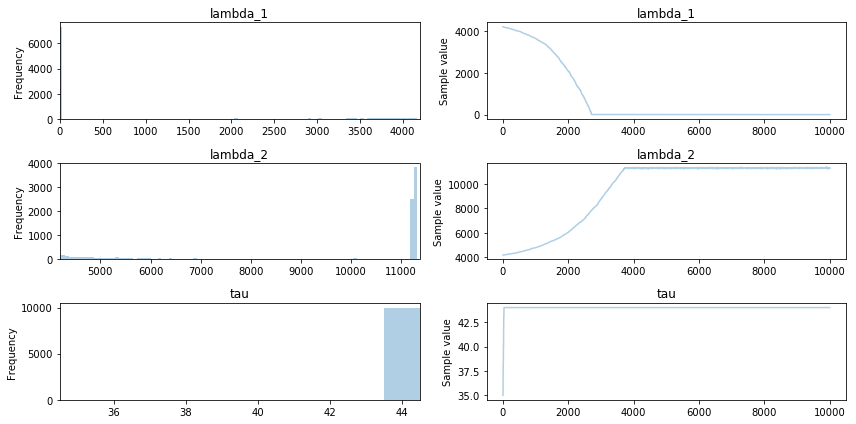

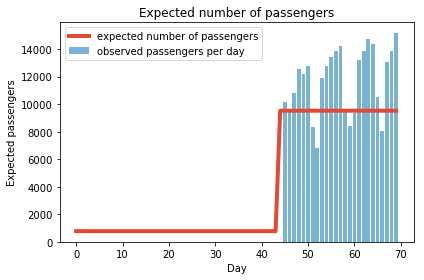

g68_in


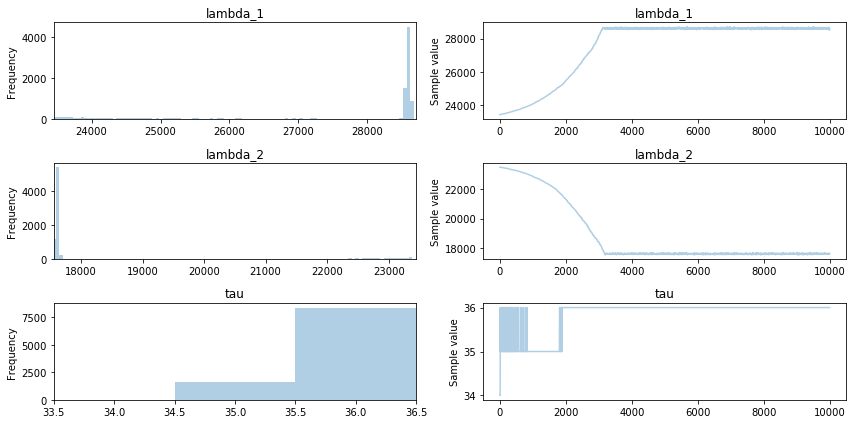

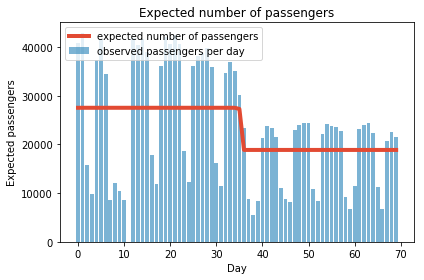

g77_in


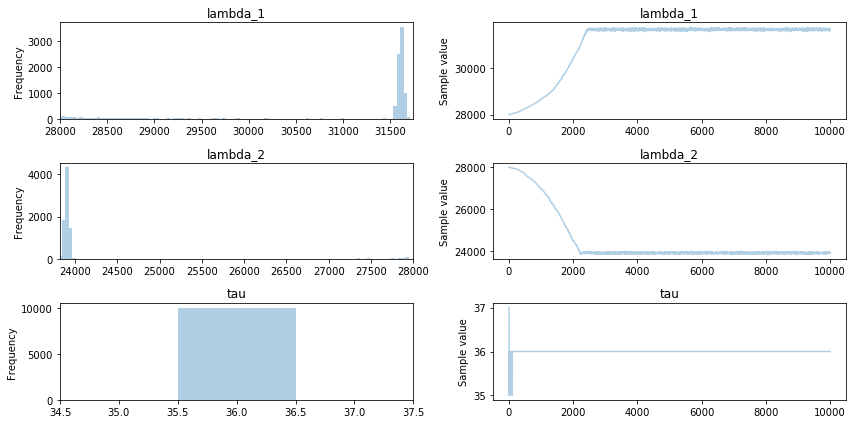

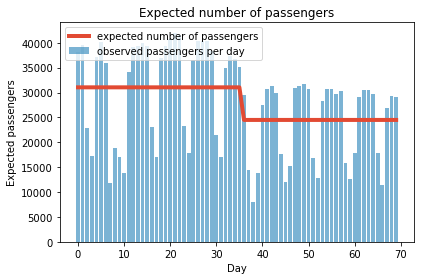

g86_in


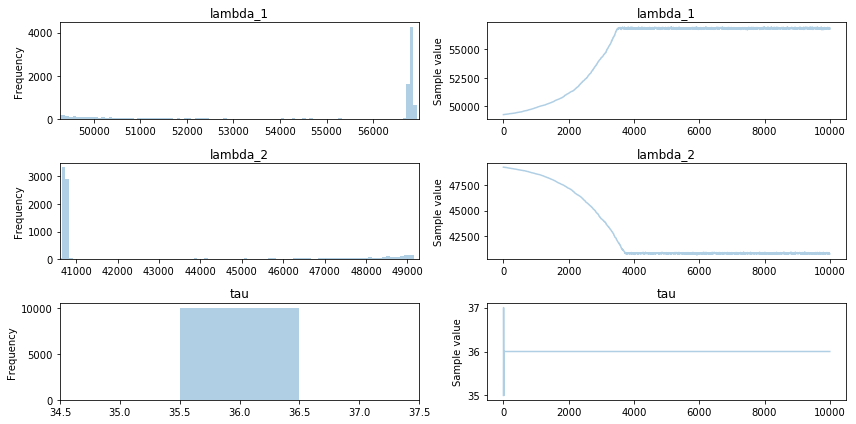

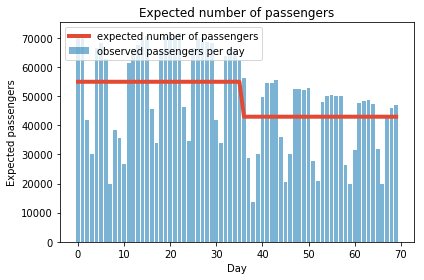

g96_in


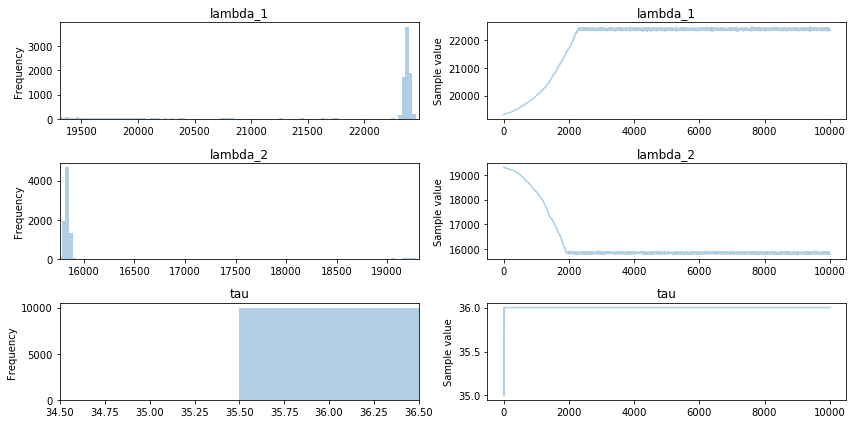

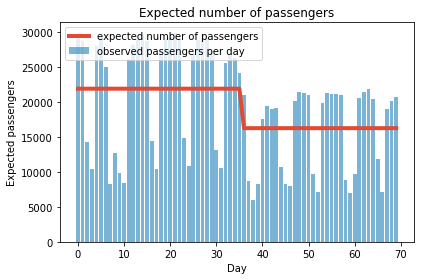

g103_in


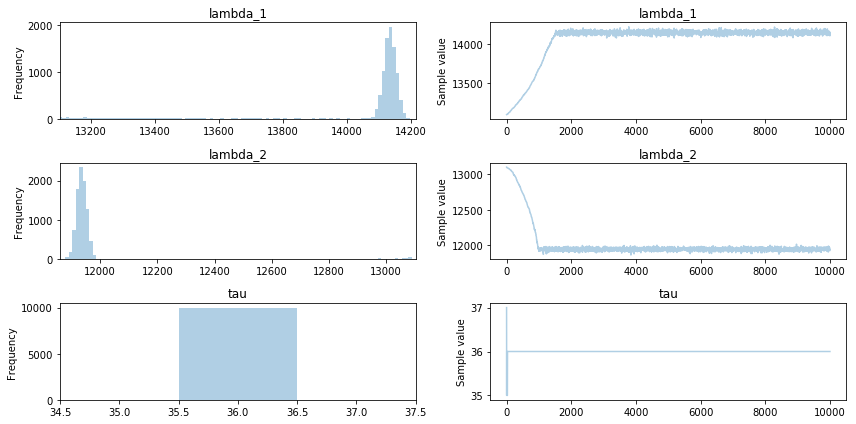

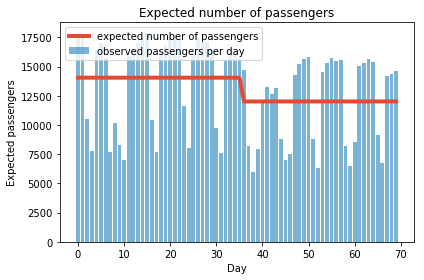

g110_in


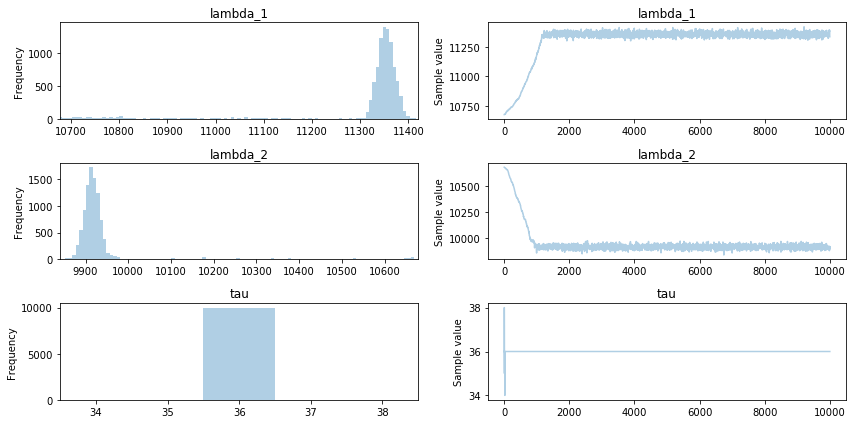

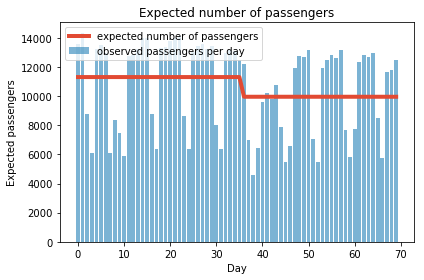

g116_in


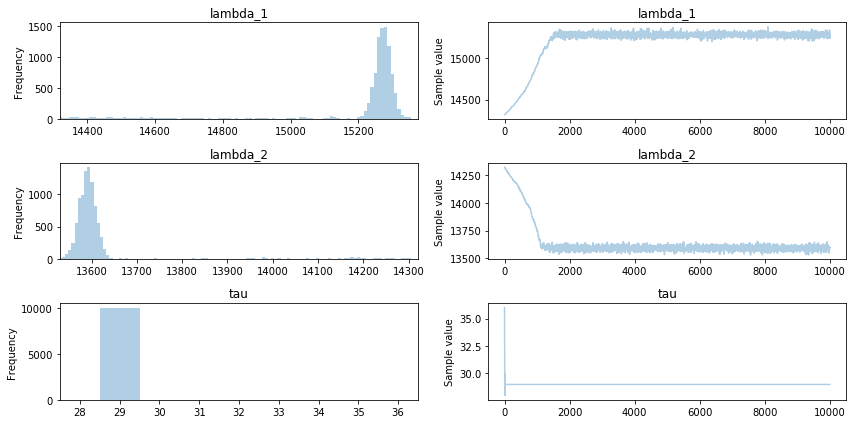

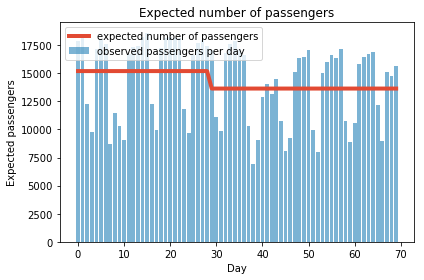

g125_in


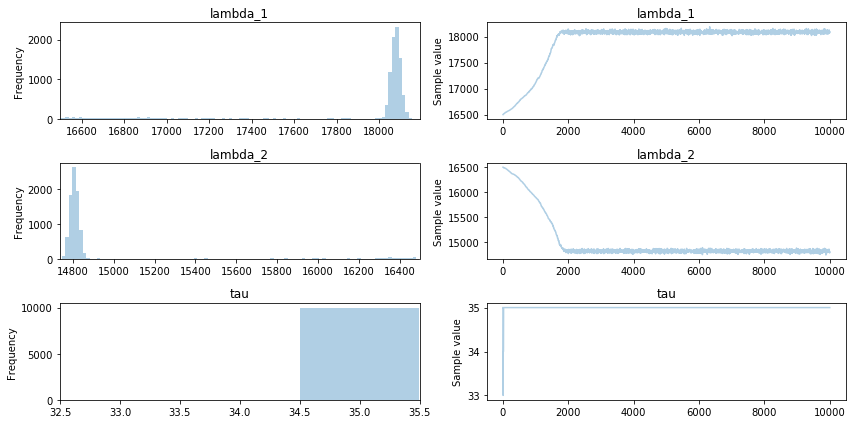

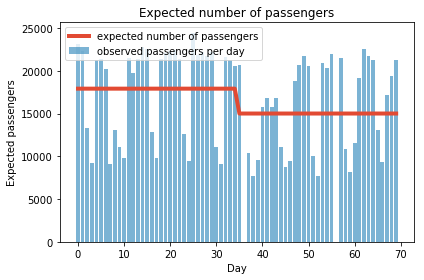

In [25]:
for trace, name in zip(results, ins):
    print(name)
    _ = pm.traceplot(trace)
    plt.show()
    plot_verify(trace, df.iloc[window][name])

In [27]:
df_ins.columns

Index(['l_in', 's72_in', 's86_in', 's96_in', 'g68_in', 'g77_in', 'g86_in',
       'g96_in', 'g103_in', 'g110_in', 'g116_in', 'g125_in'],
      dtype='object')

In [207]:
test_701a = (pd.read_sql('select * from "N701A";', conn)
               .drop(['level_0', 'index', 'division', 'desc', 'entries', 'exits'], axis=1)
               .set_index('date_time', drop=True))
test_701 = (pd.read_sql('select * from "N701";', conn)
               .drop(['level_0', 'index', 'division', 'desc', 'entries', 'exits'], axis=1)
               .set_index('date_time', drop=True))
test_701.head()

,c_a,unit,scp,station,linename,dentries,dexits
date_time,,,,,,,
2016-12-31 00:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,NaN,NaN
2016-12-31 04:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 08:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 12:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 16:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,1.0,4.0


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


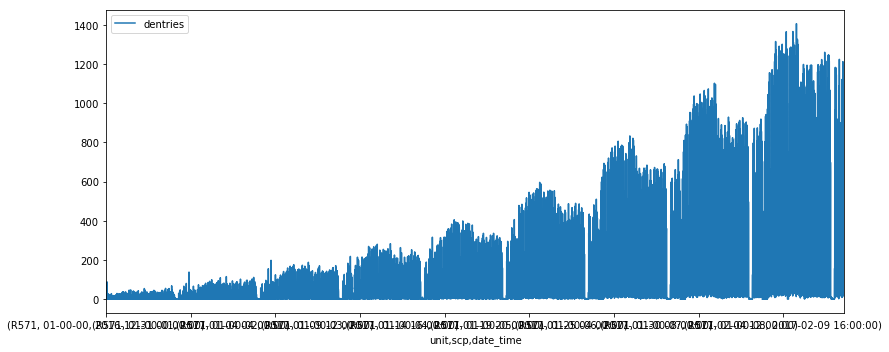

In [213]:
summed_701a = test_701a.groupby(['unit', 'scp', 'date_time']).sum()
summed_701a.dentries = np.abs(summed_701a.dentries)
summed_701a[summed_701a.dentries > 30000] = np.NaN
summed_701a.plot.line(y='dentries')

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


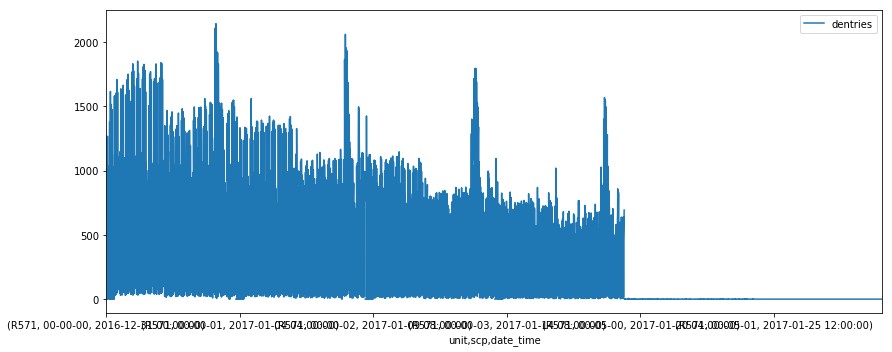

In [211]:
summed_701 = test_701.groupby(['unit', 'scp', 'date_time']).sum()
summed_701.dentries = np.abs(summed_701.dentries)
summed_701[summed_701.dentries > 30000] = np.NaN
summed_701.plot.line(y='dentries')